## This notebook studies the stochasitcity of the crossbar model

In [2]:
import sys
sys.path.append("..")

In [3]:
import matplotlib.pyplot as plt
from memristor.devices import StaticMemristor, DynamicMemristor, DynamicMemristorFreeRange, DynamicMemristorStuck
from memristor.crossbar.model import LineResistanceCrossbar
import torch
from tqdm import tqdm
import numpy as np

#### First, find appropriate programming voltage for each bitline and wordline to ensure v_p is within range

range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]

In [4]:
torch.set_default_dtype(torch.float64) # set default torch value type

In [86]:
def plot_voltage_drop(crossbar, v_wl_applied, v_bl_applied, imshow=True):
    ideal_range = []
    crossbar.lineres_memristive_vmm(v_wl_applied, v_bl_applied, iter=1)
    M = torch.t(crossbar.cache["V_wl"]-crossbar.cache["V_bl"])
    if imshow:
        im = plt.imshow(M,
                        interpolation='none', aspect='equal')
        ax = plt.gca()
        # no need for axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Cell voltage TiOx crossbar")
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        plt.colorbar()
        plt.show()
    # show % within range
    bt1 = torch.numel(M[(-1.5<=M) & (M<=-0.8)])/torch.numel(M)
    bt2 = torch.numel(M[(0.8<=M) & (M<=1.15)])/torch.numel(M)
    if imshow:
        print(f"percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: {100*max(bt1, bt2)}%:")
    return 100*max(bt1, bt2)

In [87]:
crossbar_params = {'r_wl': 20, 'r_bl': 20, 'r_in':10, 'r_out':10, 'V_SOURCE_MODE':'|_|'}
memristor_model = DynamicMemristorStuck
memristor_params = {'frequency': 1e8, 'temperature': 60+273}
ideal_w = 65*torch.ones(48, 16)*1e-6

In [88]:
crossbar = LineResistanceCrossbar(memristor_model, memristor_params, ideal_w, crossbar_params)

In [89]:
best_v_wl_applied = 1.2 * torch.concat([1.2*torch.ones(12,), torch.linspace(1.2, 1, 4)], dim=0)#torch.concat([3.1*torch.ones(12,), torch.linspace(3.1, 2.4,4)], dim=0)
best_v_bl_applied = 1.5 * torch.concat([torch.linspace(1, 1.2,16), 1.2*torch.ones(16,),torch.linspace(1.2, 1,16)], dim=0)

##### Reset operation cell voltage drop

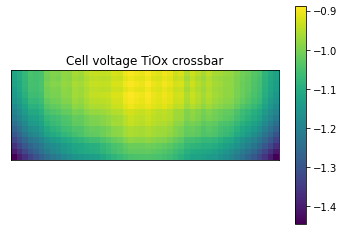

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:


100.0

In [90]:
plot_voltage_drop(crossbar, 0*torch.ones(16,), best_v_bl_applied)

##### Set operation cell voltage drop

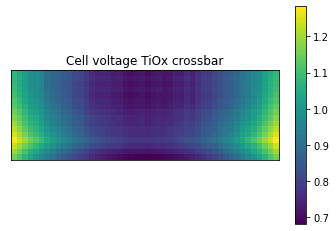

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 54.166666666666664%:


54.166666666666664

In [91]:
plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(48,))

#### Now we can apply programming voltage

In [92]:
# useful functions
def program_crossbar(crossbar, v_wl_applied, v_bl_applied, t_p, iterations, imshow=True):
    ideal_w_hist=[]
    fitted_w_hist=[]
    for i in range(iterations):
        #  program the crossbar
        ideal_w_hist.append(torch.clone(crossbar.ideal_w).view(-1))
        fitted_w_hist.append(torch.clone(crossbar.fitted_w).view(-1))
        crossbar.lineres_memristive_programming(v_wl_applied, v_bl_applied, t_p)
    # conductance change history
    ideal_w_hist = torch.stack(ideal_w_hist, dim=1)
    fitted_w_hist = torch.stack(fitted_w_hist, dim=1)
    if imshow:    
        for i in range(ideal_w_hist.shape[0]):
            plt.plot(range(iterations), ideal_w_hist[i, :]*1e6)
        plt.title("ideal conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([1, 400])
        plt.yscale('log')
        plt.show()
        
        for i in range(fitted_w_hist.shape[0]):
            plt.plot(range(iterations), fitted_w_hist[i, :]*1e6)
        plt.title("fitted conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([1, 400])
        plt.yscale('log')
        plt.show()
    #print(ideal_w_hist.shape, fitted_w_hist.shape)
    return ideal_w_hist, fitted_w_hist
        
def crossbar_statistics(crossbar, txt=""):
    print(txt)
    plt.matshow(torch.t(crossbar.ideal_w)*1e6)
    plt.title("ideal conductance")
    plt.clim(10, 150)
    plt.colorbar()
    plt.show()
    # best fit conductance
    plt.matshow(torch.t(crossbar.fitted_w)*1e6)
    plt.title("fitted conductance")
    plt.clim(0, 150)
    plt.colorbar()
    plt.show()

    # Histograms
    hist, bins = np.histogram(crossbar.ideal_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("ideal conductance histogram")
    plt.xlabel("conductance (uS)")
    #plt.xlim([1, 400])
    #plt.xscale('log')
    plt.show()

    hist, bins = np.histogram(crossbar.fitted_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("fitted conductance histogram")
    plt.xlabel("conductance (uS)")
    #plt.xlim([1, 400])
    #plt.xscale('log')
    plt.show()
    
    #stuck memristors
    stuck_mask = [[0 if crossbar.memristors[i][j].stuck else 1 for j in range(ideal_w.shape[1])] for i in range(ideal_w.shape[0])]
    stuck_mask = torch.t(torch.tensor(stuck_mask))
    plt.title("stuck memristors")
    plt.matshow(stuck_mask)
    plt.colorbar()
    plt.show()
    print("% stuck:", f"{100-torch.sum(stuck_mask)/torch.numel(stuck_mask) * 100}%")
    print("reset in range:", plot_voltage_drop(crossbar, 0*torch.ones(16,), best_v_bl_applied, imshow=False))
    print("set in range:", plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(48,), imshow=False))

##### Multi-cycle programming

In [93]:
t_p_set = 0.25e-3
t_p_reset = 0.5e-3
n_set = 15
n_reset = 40
cycles = 6

cycle 0


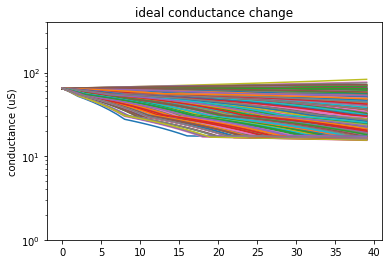

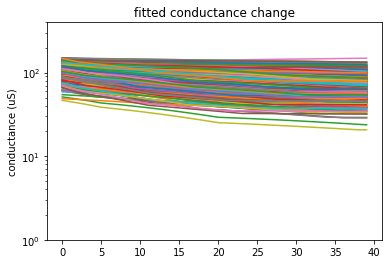

reset at cycle 0


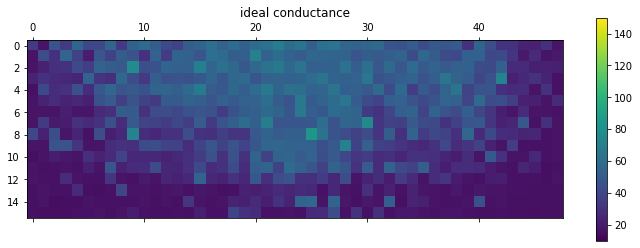

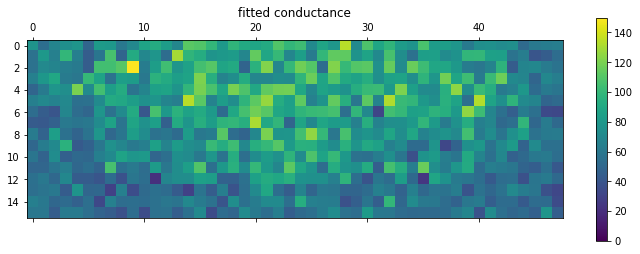

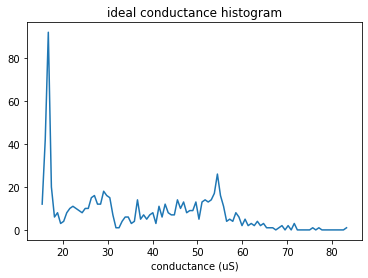

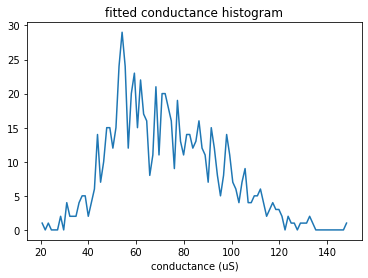

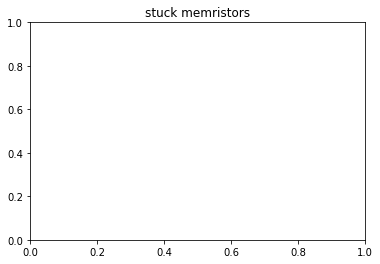

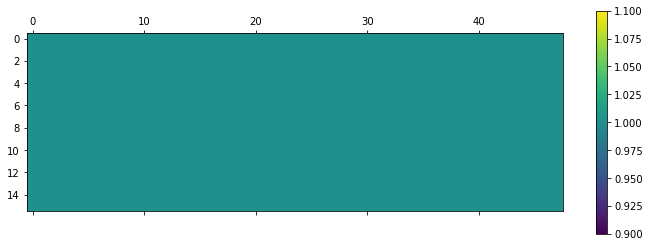

% stuck: 0.0%
reset in range: 100.0
set in range: 73.95833333333334


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


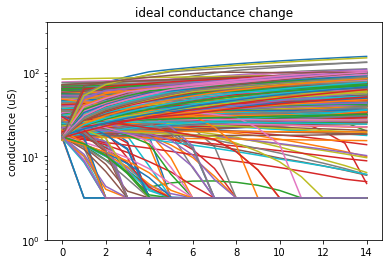

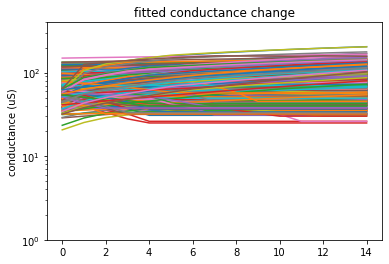

set at cycle 0


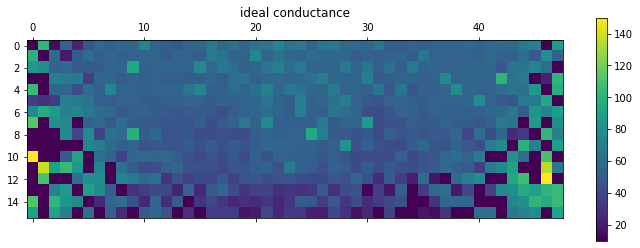

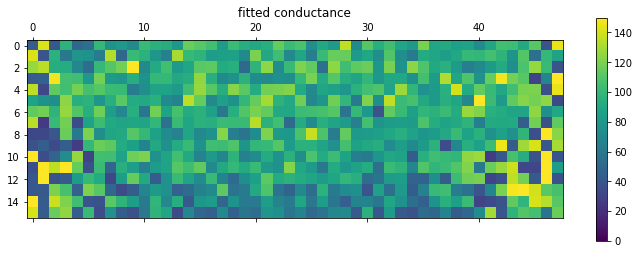

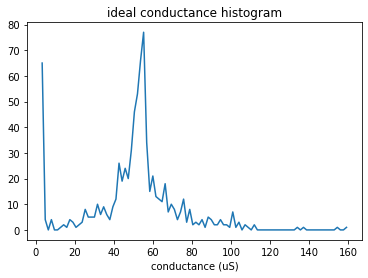

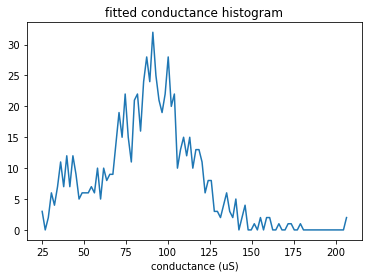

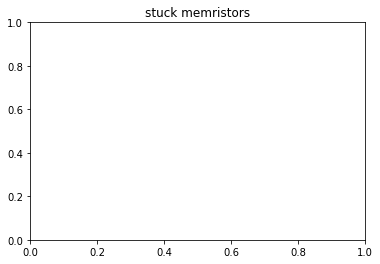

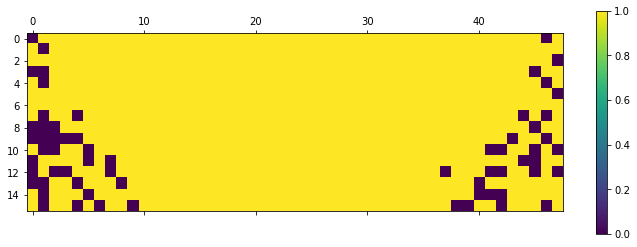

% stuck: 8.333333333333343%
reset in range: 100.0
set in range: 75.65104166666666
cycle 1


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


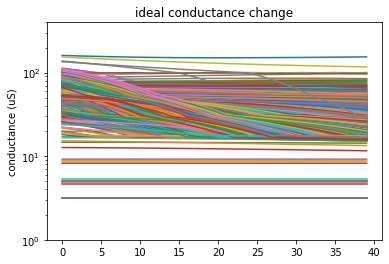

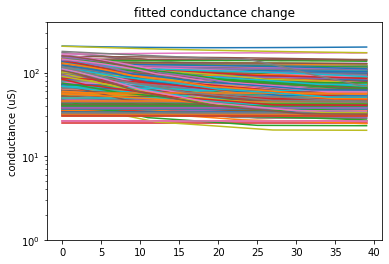

reset at cycle 1


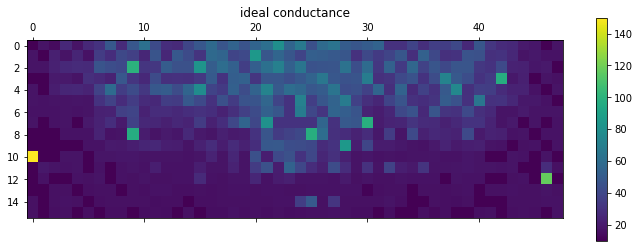

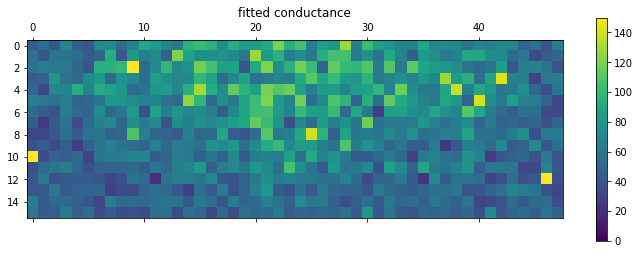

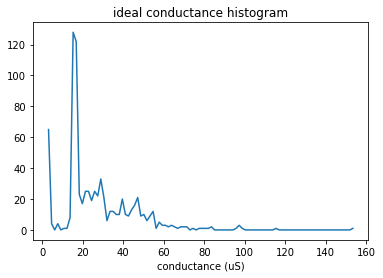

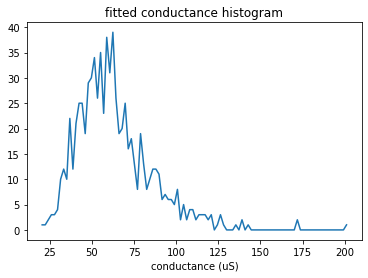

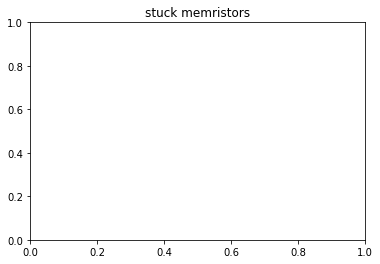

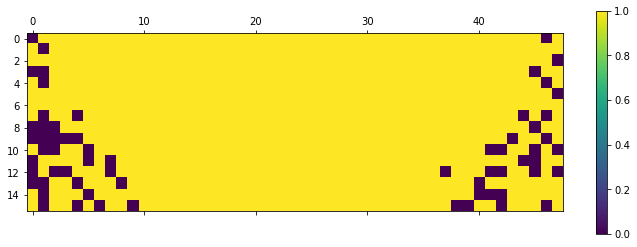

% stuck: 8.333333333333343%
reset in range: 100.0
set in range: 76.04166666666666


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


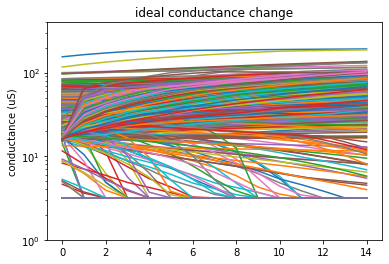

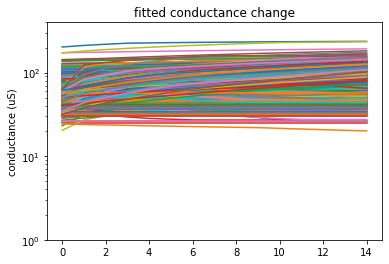

set at cycle 1


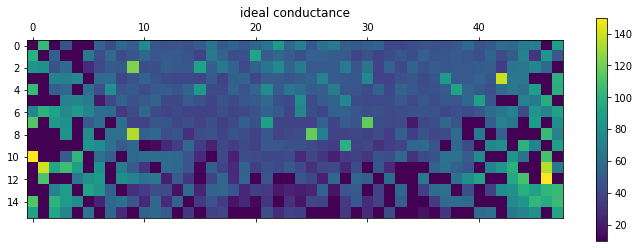

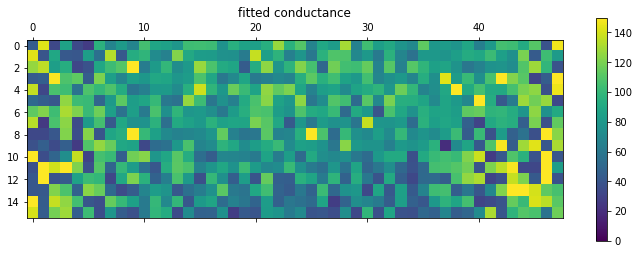

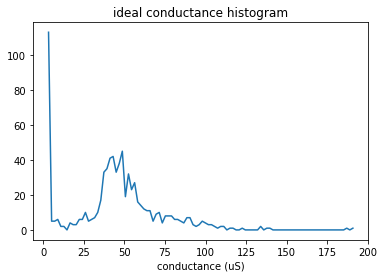

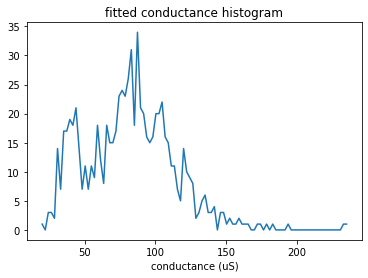

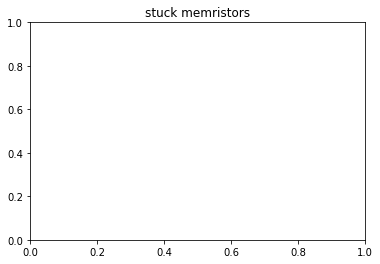

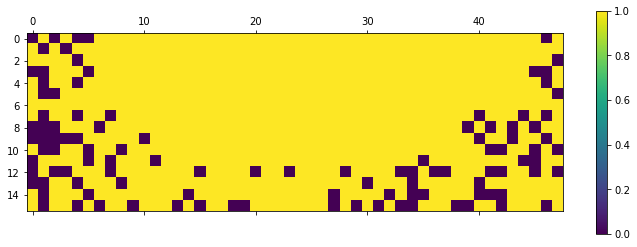

% stuck: 14.0625%
reset in range: 100.0
set in range: 83.203125
cycle 2


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


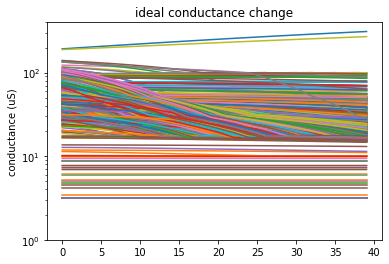

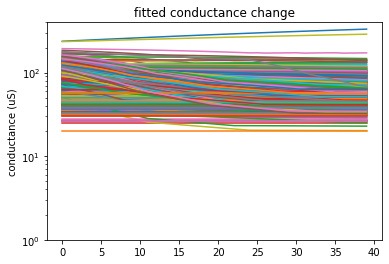

reset at cycle 2


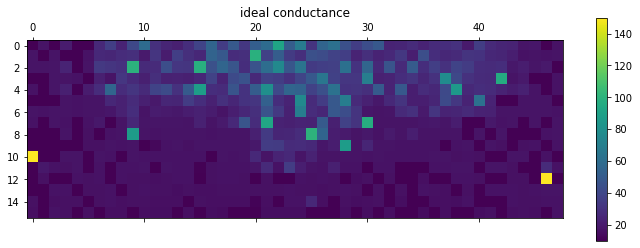

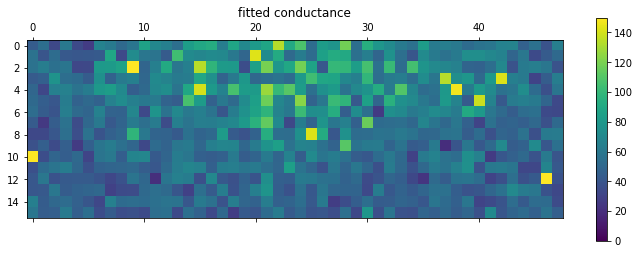

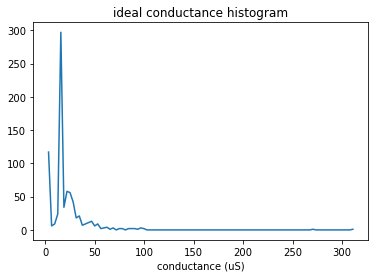

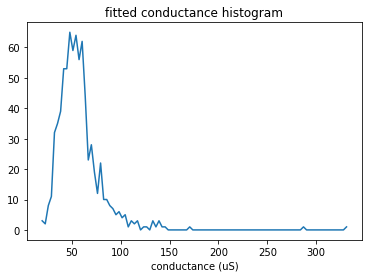

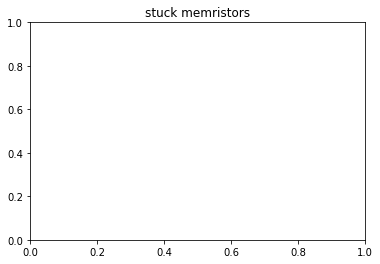

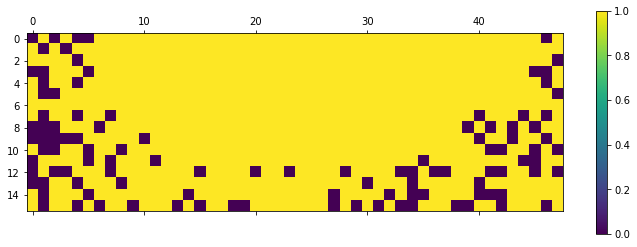

% stuck: 14.0625%
reset in range: 100.0
set in range: 75.52083333333334


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


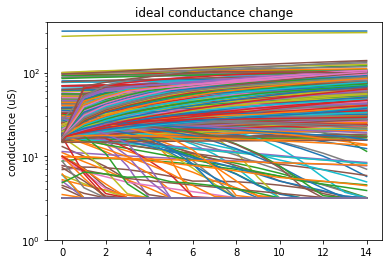

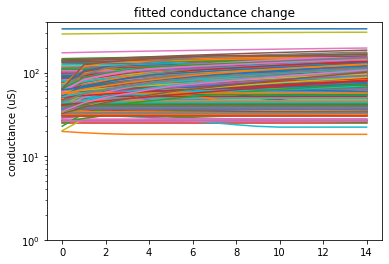

set at cycle 2


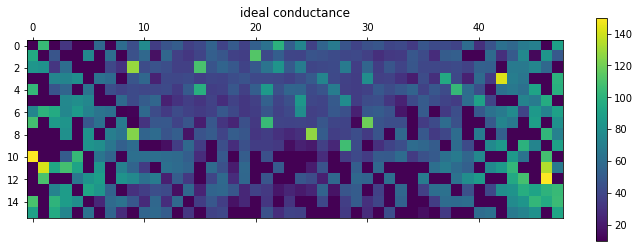

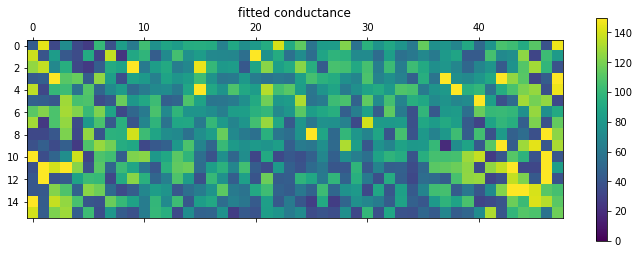

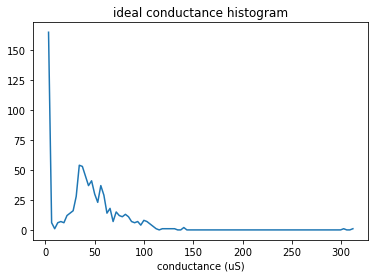

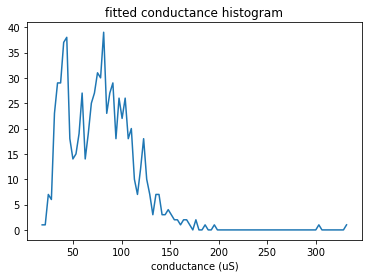

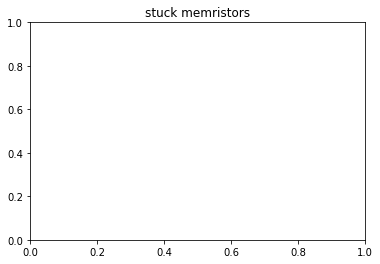

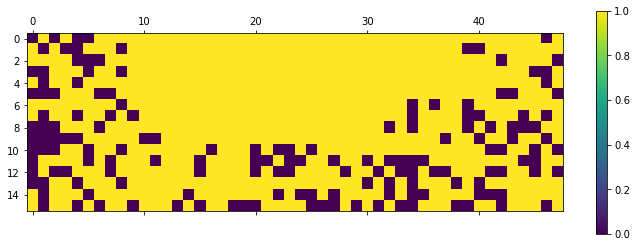

% stuck: 20.703125%
reset in range: 100.0
set in range: 89.32291666666666
cycle 3


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


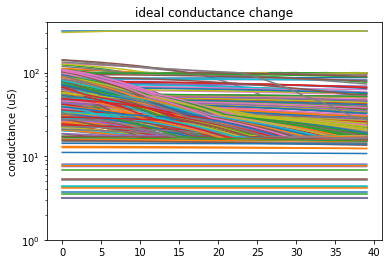

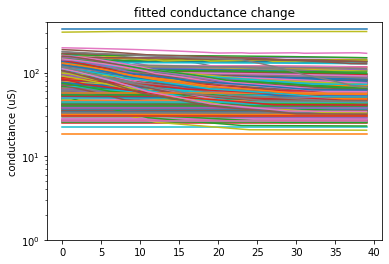

reset at cycle 3


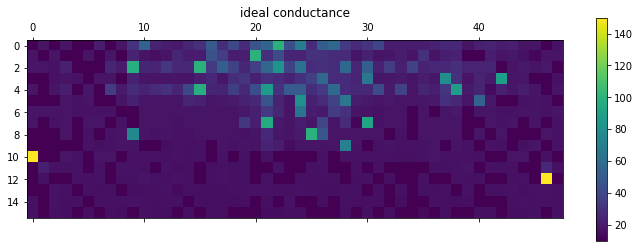

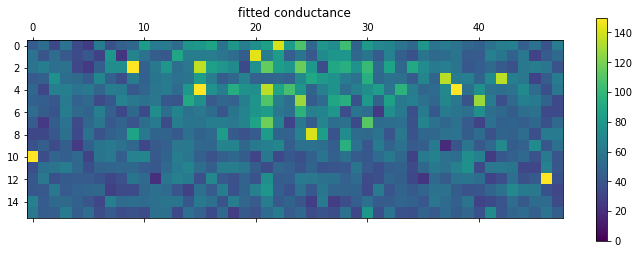

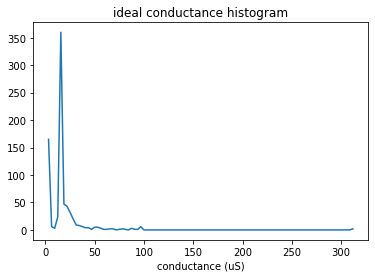

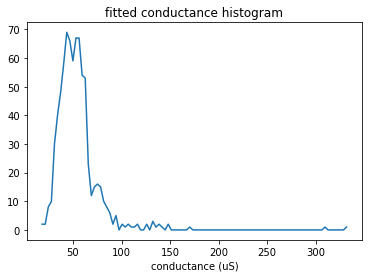

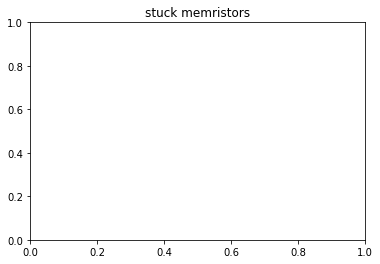

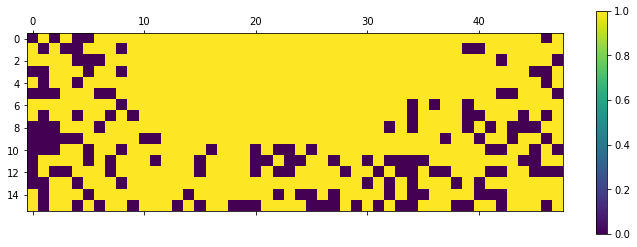

% stuck: 20.833333333333343%
reset in range: 100.0
set in range: 74.08854166666666


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


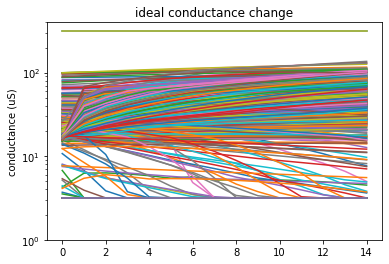

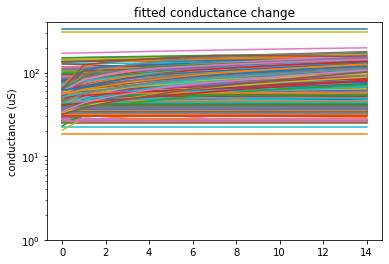

set at cycle 3


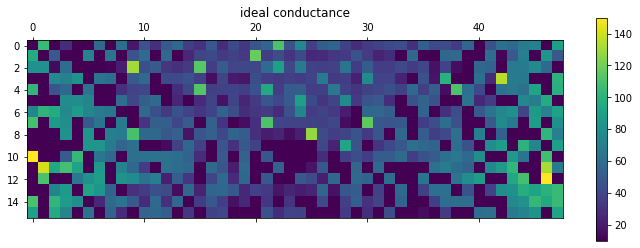

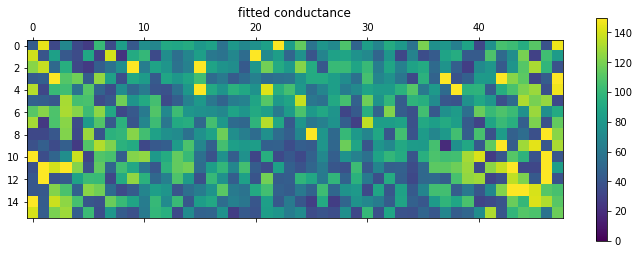

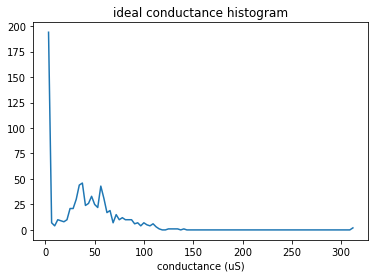

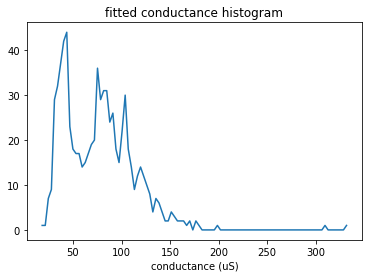

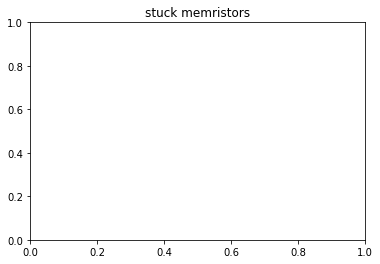

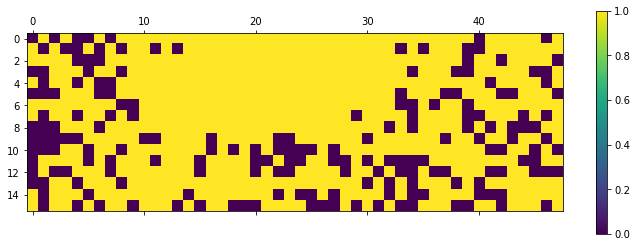

% stuck: 24.479166666666657%
reset in range: 100.0
set in range: 92.44791666666666
cycle 4


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


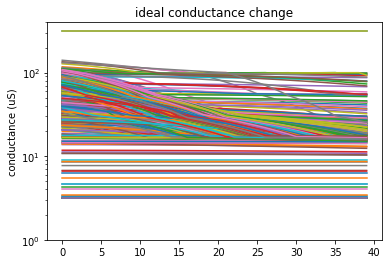

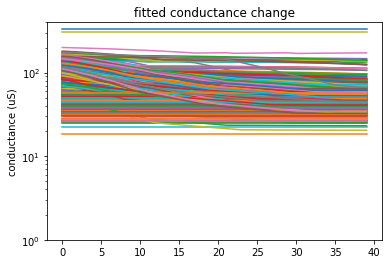

reset at cycle 4


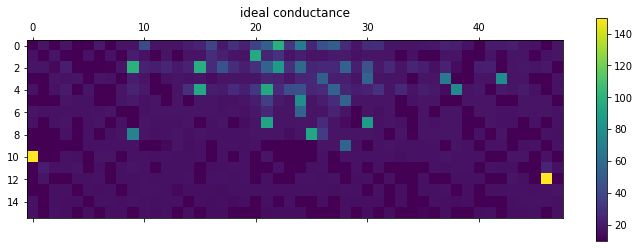

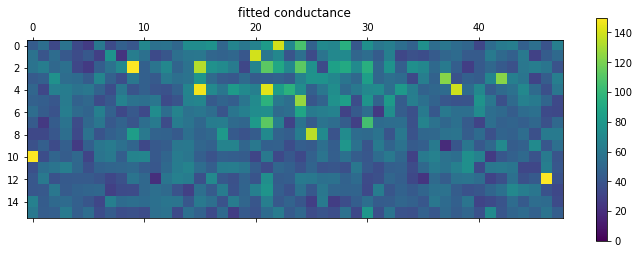

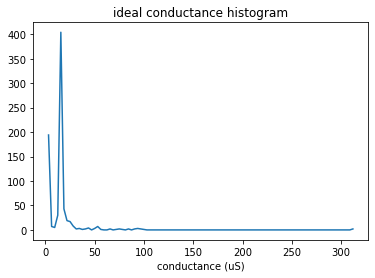

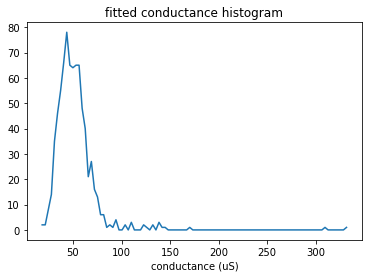

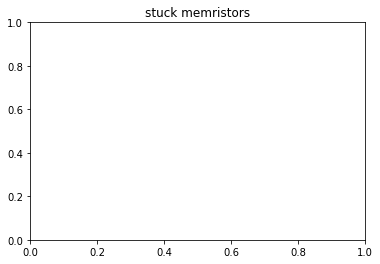

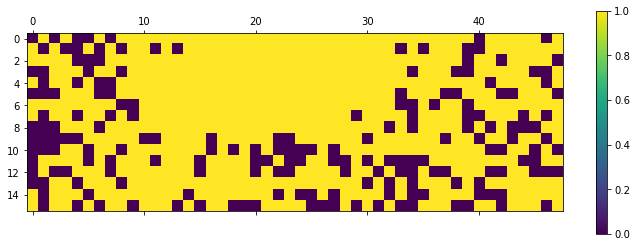

% stuck: 24.479166666666657%
reset in range: 100.0
set in range: 72.52604166666666


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


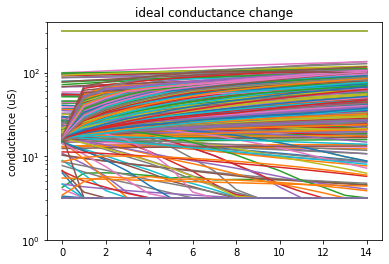

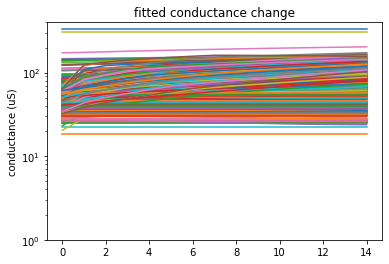

set at cycle 4


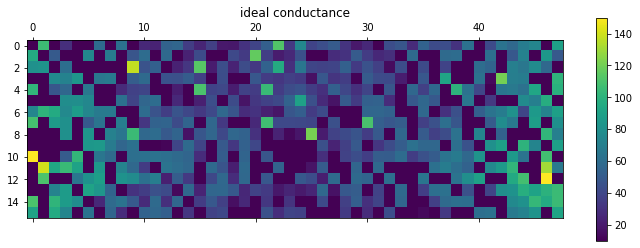

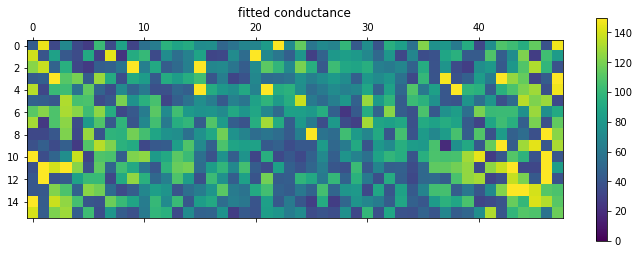

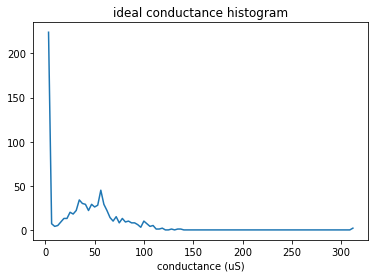

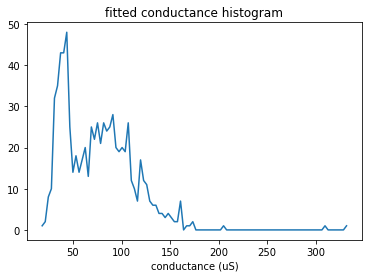

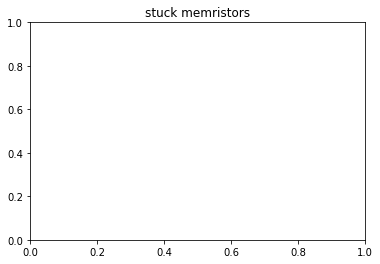

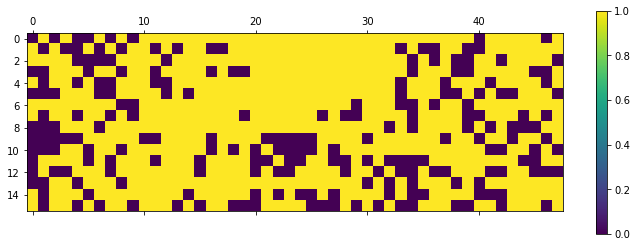

% stuck: 28.125%
reset in range: 100.0
set in range: 93.48958333333334
cycle 5


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


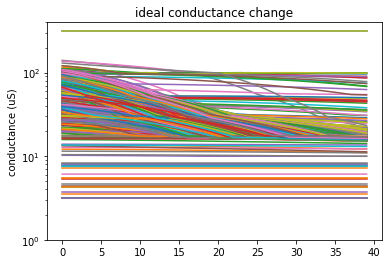

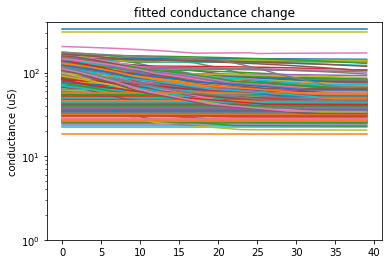

reset at cycle 5


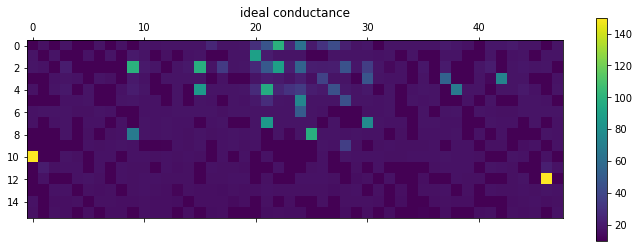

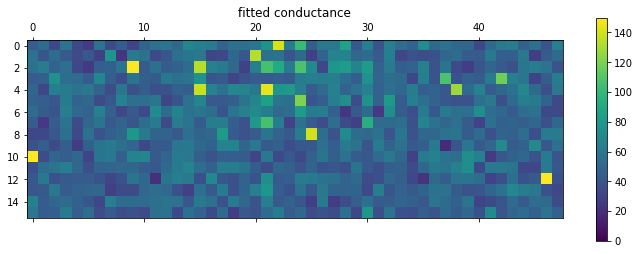

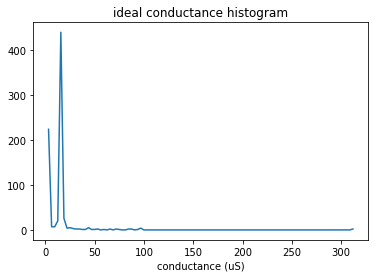

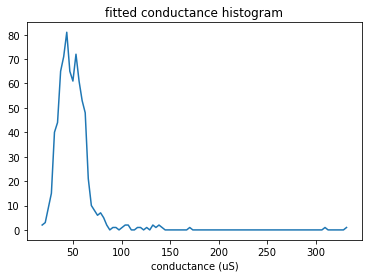

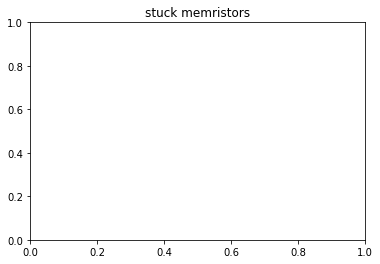

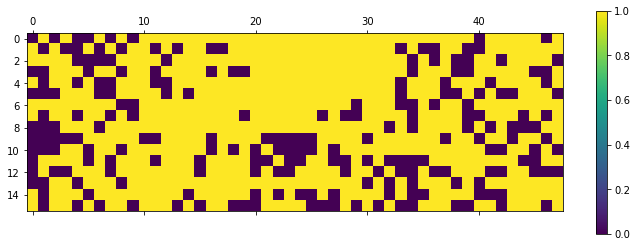

% stuck: 28.125%
reset in range: 100.0
set in range: 71.875


/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


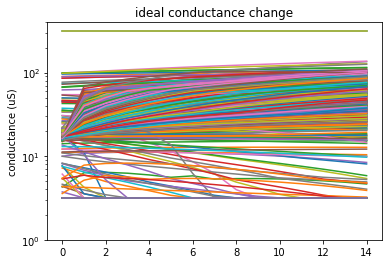

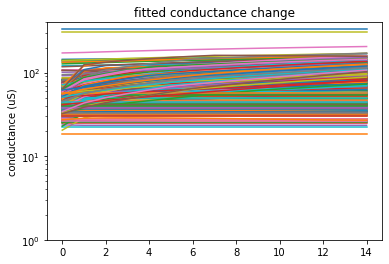

set at cycle 5


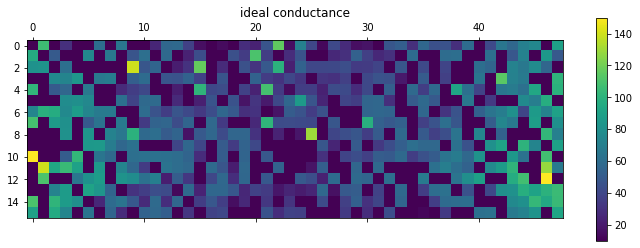

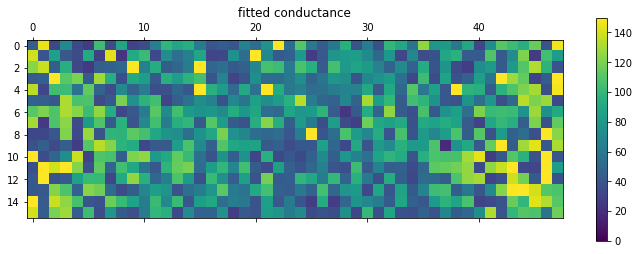

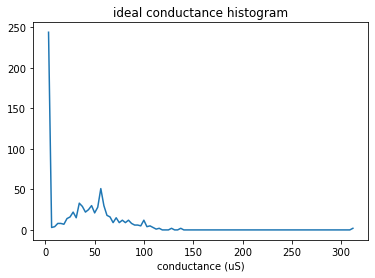

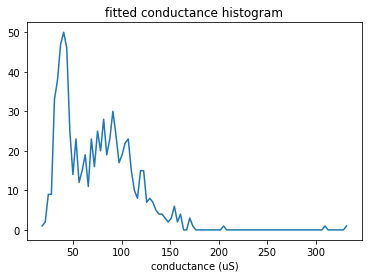

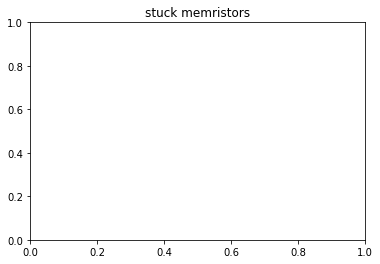

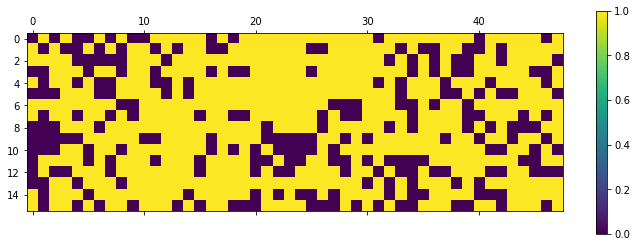

% stuck: 30.729166666666657%
reset in range: 100.0
set in range: 93.48958333333334


In [94]:
ideal_conductance_hist = torch.zeros([crossbar.m*crossbar.n, cycles*(n_set+n_reset)])
fitted_conductance_hist = torch.zeros([crossbar.m*crossbar.n, cycles*(n_set+n_reset)])
#weight_checkpoint = {"ideal":torch.zeros([]), "fitted":torch.zeros([])}
for i in range(cycles):
    print(f"cycle {i}")
    # first reset
    ideal_conductance_hist[:,i*(n_reset+n_set):i*(n_reset+n_set)+n_reset], fitted_conductance_hist[:,i*(n_reset+n_set):i*(n_reset+n_set)+n_reset] \
    = program_crossbar(crossbar, torch.zeros(16,), best_v_bl_applied, t_p_reset, n_reset, imshow=True)
    crossbar_statistics(crossbar, txt=f"reset at cycle {i}")
    # then set
    ideal_conductance_hist[:,i*(n_reset+n_set)+n_reset:(i+1)*(n_reset+n_set)], fitted_conductance_hist[:,i*(n_reset+n_set)+n_reset:(i+1)*(n_reset+n_set)] \
    = program_crossbar(crossbar, best_v_wl_applied, torch.zeros(48,), t_p_set, n_set, imshow=True)
    crossbar_statistics(crossbar, txt=f"set at cycle {i}")

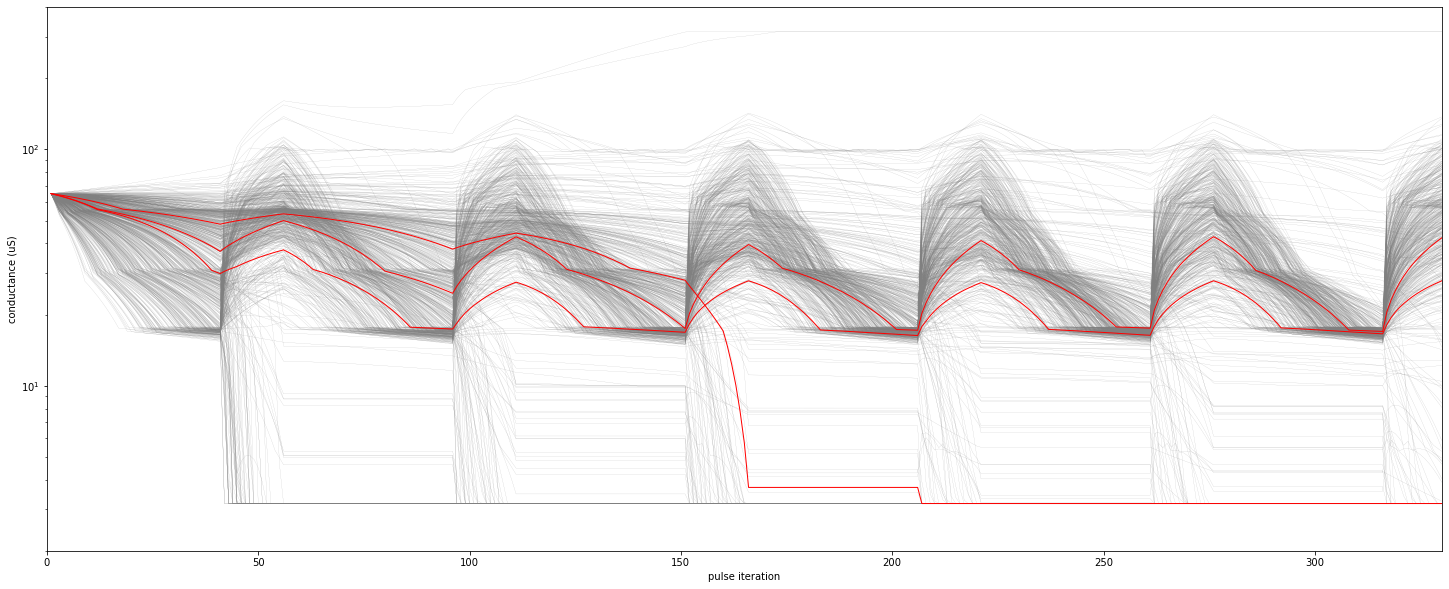

In [101]:
# plot ideal
for i in range(crossbar.m*crossbar.n):
    if i == 100 or i == 300 or i == 600:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), ideal_conductance_hist[i,:]*1e6, color="red", zorder = 2, linewidth=1)
    else:
        plt.plot(range(1, cycles*(n_set+n_reset)+1), ideal_conductance_hist[i,:]*1e6, color="gray", zorder = 1, linewidth=0.1)

plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([2,400])
plt.xlim([0, cycles*(n_set+n_reset)])
fig = plt.gcf()
fig.set_size_inches(25, 10)
plt.show()

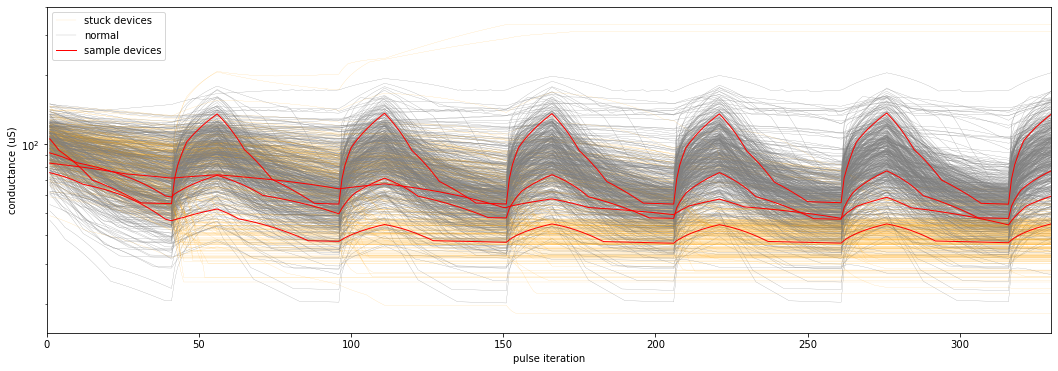

In [121]:
# plot ideal
stuck_mask = [[0 if crossbar.memristors[i][j].stuck else 1 for j in range(ideal_w.shape[1])] for i in range(ideal_w.shape[0])]
stuck_mask = torch.tensor(stuck_mask).view(-1)
c1, c2, c3 = 0,0,0
for i in range(crossbar.m*crossbar.n):
    if i == 200 or i==300 or i == 400 or i==700:
        if c1 == 0:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="red", zorder = 2, linewidth=1, label = "sample devices")
            c1+=1
        else: 
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="red", zorder = 2, linewidth=1)
    elif stuck_mask[i] == 0:
        if c2 == 0:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="orange", zorder = 1, linewidth=0.1, label = "stuck devices")
            c2+=1
        else:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="orange", zorder = 1, linewidth=0.1)
    else:
        if c3 == 0:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="gray", zorder = 1, linewidth=0.2, label = "normal")
            c3+=1
        else:
            plt.plot(range(1, cycles*(n_set+n_reset)+1), fitted_conductance_hist[i,:]*1e6, color="gray", zorder = 1, linewidth=0.2)            

plt.xlabel("pulse iteration")
plt.ylabel("conductance (uS)")
plt.yscale('log')
plt.ylim([15,400])
plt.xlim([0, cycles*(n_set+n_reset)])
plt.legend()
fig = plt.gcf()
fig.set_size_inches(18, 6)
plt.show()
fig.savefig('crossbar_conductance_cycle.png', dpi=100)